In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Logbook 2: Danny Phan (21001091)

## Working on Runge-Kutta and checking my progress so far (22/02/2023)

So, after an 11 day break over reading week I think I'll get started on section 3.5, using a different integrator to evolve one of the systems in section 3.2-3.4. This integrator will be the Runge-Kutta integrator (4th order of course). For simplicity, I think it would be wise to just do this for section 3.2 (two bodies, different masses). I still haven't made any edits to my original Overleaf document, but I think I can do that later. In terms of the extension project, as much as I want to be creative and look at something different, I think just doing the N-body choreographics seems already very interesting, and it saves me the time researching other problems to model which may prove to be even more challenging.

However, looking at the Wikipedia page for the n-body problem, there are some really cool things that are semi-related that I could study, such as the simulation of proteins and cellular assemblies in structural biology, or modelling fluid flow using something called Vortex Methods (?), but these aren't related to gravitation, and are all very ambitious, and very, very difficult.

Nevertheless, I will now begin looking at using Runge-Kutta. I won't bother presenting how it works, since that'll be in the report.

Now, I'll need to break down the differential equation into two coupled equations, and write a function for them, and then use the RK4 solver to solve them.

Breaking down the equation:

$$ \vec{F_1} = \frac{Gm_1m_2}{r_{12}^3} \vec{r_{12}} $$

$$ m_1 \frac{d^2\vec{r_{12}}}{dt^2} = \frac{Gm_1m_2}{r_{12}^3} \vec{r_{12}} $$

$$ \frac{d^2\vec{r_{12}}}{dt^2} = \frac{Gm_2}{r_{12}^3} \vec{r_{12}} $$

Decoupling

$$ \frac{d\vec{r_{12}}}{dt} = \vec{v_{12}}$$
$$ \frac{d\vec{v_{12}}}{dt} = \frac{\vec{F}}{m_1} = \frac{Gm_2}{r_{12}^3}\vec{r_{12}} $$

So we can say that $\Delta \vec{r} = \vec{v}\Delta t$ and $\Delta \vec{v} = \vec{F}\Delta t / m $ '

After spending a few hours on this, I can't seem to make any headway, I will be back.

# Trying again (23/02/2023)

I had some trouble thinking about how best to implement the Runge-Kutta solver. The exercise solutions in week 4 use an array, y (that contains both of the variables together), in the `RHS_function` function. The problem for me is how can I make this `y` contain two arrays? My previous idea (which didn't work) was to create a 3_D array containing the entire array of position and the entire array of velocity (including the next time steps), however I was having trouble iterating over each timestep. I think a different way of doing this is to separate `y` by timestep, i.e., for each timestep, I want there to be an array containing the arrays of position and velocity. Then this collection of all of the arrays is `y`. 

In [2]:
initial_position = np.array([1,0])

initial_velocity = np.array([0,1])

N = 120 # Number of steps

y = np.array([initial_position, initial_velocity])

# Now I want to add a bunch of zeros for the next index

Y1 = np.zeros((N,2,2)) 

Y1[0] = np.copy(y)

#Uncomment if you want to see the whole array

#print(f"{Y1} \n") # So now we have a list of matrices, these matrices contain the velocity and the position arrays.

print(f"The first initial positions and velocities are \n{Y1[0]}")

print(f"The initial position vector is \n {Y1[0,0]}")


The first initial positions and velocities are 
[[1. 0.]
 [0. 1.]]
The initial position vector is 
 [1. 0.]


Now I think I need to input just the first time step into the `RHS` function, so that would be just `Y1[0]`

In [3]:
def RHS_gravity(Y, t):
    """
    This implements the finite differences for the decoupled differential equation of motion. 
    The maths equations for this are detailed above.
    
    Inputs:
    Y_n    This is a matrix array at a specific time, part of a whole list of matrix arrays at different timesteps
    t      time (unused)
    
    Outputs:
    dY_n   An array containing the position and velocity vectors
    """
    
    m2 = 1.0
    
    R12 = np.array([0,0]) - Y[0] # m2 is fixed at the origin so it will always have position (0,0), this would not be the case
                                 # if we didn't have a fixed m2. 
    
    R12_mag_cubed = np.linalg.norm(R12) **3
    
    # Unpack Y for clarity
    
    position = Y[0]
    
    velocity = Y[1]
    
    dpos = velocity
    
    dvel = (1.0 * m2 * R12) / R12_mag_cubed # G = 1
    
    return np.array((dpos,dvel))

So if we implement this function, we should see that the next timestep, `Y[1]`, should be some 2x2 array.

Now we'll try to make the Runge-Kutta solver.

In [4]:
t = 0
RHS_gravity(Y1[0],t) # It works!

array([[ 0.,  1.],
       [-1.,  0.]])

In [5]:
def RK4_solver(fun, Y, N, dt):
    """
    This is a fourth order Runge-Kutta integrator adapted from Question 1 of Chapter 5 of the Session 4 in-class exercises. 
    It has been modified to exclude initial conditions, but otherwise it's pretty much the same.
    
    Inputs:
    fun   an update function that that splits up the position and velocity components and increments them
    Y     the array we are updating with function, this is a 3-D array made of the velocity and position vectors at each timestep
    N     the number of steps we take
    dt    the step size
    
    Outputs:
    Y     Returns the function after we have updated it using the Runge-Kutta integrator method.
    """
    
    # I have already constructed Y so there's no need to input a y0 or make any new arrays
    
    t = 0

    
    for i in range(N-1):
        k1 = dt * fun(Y[i], t)
        k2 = dt * fun(Y[i]+0.5*k1, t+0.5*dt)
        k3 = dt * fun(Y[i]+0.5*k2, t+0.5*dt)
        k4 = dt * fun(Y[i]+k3, t+dt)
        
        Y[i+1] = Y[i]+(k1+2*k2+2*k3+k4)/6
        t += dt
    return Y

In [6]:
dt = 0.1
res = RK4_solver(RHS_gravity, Y1, N, dt)
print(np.size(res))

480


In [7]:
# This is simply to help myself understand what my arrays are

# print(res[0,0]) # This is position at time 0
# print(res[1,0]) # This is position at time 1
# 
# print(res[:,0]) # These are all the positions
# 
# print(res[:,0,0]) # These are all the x positions
# print(res[:,0,1]) # These are all the y positions

#print(res[:,1,0]) # These are all the x velocities
#print(res[:,1,1]) # These are all the y velocities

#print(res[:,1,:]) # These are all of the velocities

#print(res[:,1,0])

#print(res[2,1,0]) # This is the 3rd x velocity

#print(res[2,1,1]) # This is the 3rd y velocity

#np.linalg.norm(res[:,1,:])

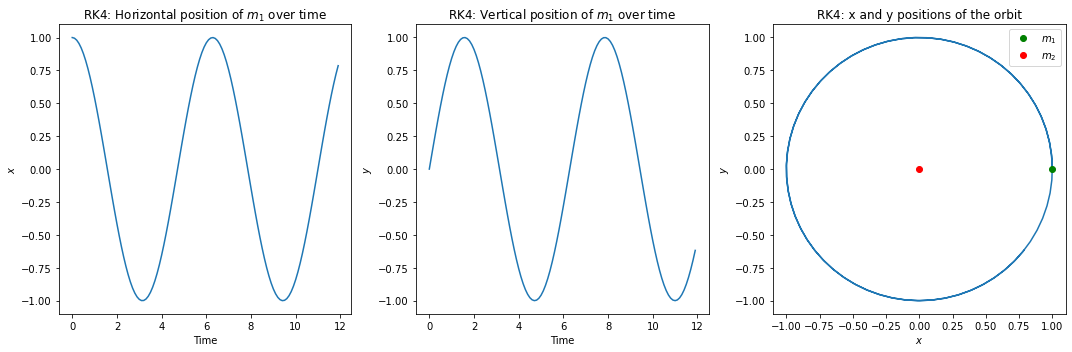

In [8]:
tarr = np.arange(0, N * dt, dt)

figs, ax = plt.subplots(1,3, figsize = (15,5), tight_layout = True)

ax[2].plot(res[:,0,0],res[:,0,1])
ax[2].set_title("RK4: x and y positions of the orbit")
ax[2].plot(1,0,'bo', color = "green", label = r"$m_1$")
ax[2].plot(0,0,'bo', color = "red", label = r"$m_2$")
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$y$')

ax[0].plot(tarr, res[:,0,0])
ax[0].set_title(r"RK4: Horizontal position of $m_1$ over time")
ax[0].set_xlabel(r'Time')
ax[0].set_ylabel(r'$x$')

ax[1].plot(tarr, res[:,0,1])
ax[1].set_title(r"RK4: Vertical position of $m_1$ over time")
ax[1].set_xlabel(r'Time')
ax[1].set_ylabel(r'$y$')

ax[2].legend(loc = 'best')

plt.savefig("rk4plot.jpg", dpi=300)

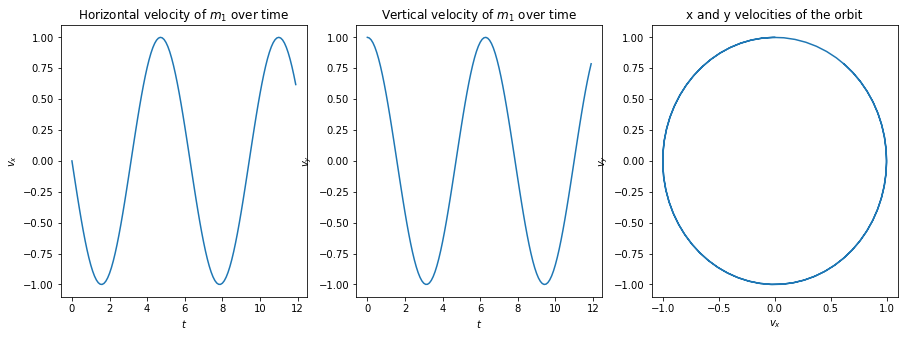

In [9]:
tarr = np.arange(0, N * dt, dt)

figs, ax = plt.subplots(1,3, figsize = (15,5))


ax[0].plot(tarr, res[:,1,0])
ax[0].set_title(r"Horizontal velocity of $m_1$ over time")
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$v_x$')

ax[1].plot(tarr, res[:,1,1])
ax[1].set_title(r"Vertical velocity of $m_1$ over time")
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$v_y$')

ax[2].plot(res[:,1,0],res[:,1,1])
ax[2].set_title("x and y velocities of the orbit")
ax[2].set_xlabel(r'$v_x$')
ax[2].set_ylabel(r'$v_y$')
plt.savefig("rk4vel.jpg", dpi=300)

Wow, I did not expect this to be working so easily, and the whole idea was really quite difficult to think about. Now let's try and examine the conservation of angular momentum and energy of the system. Since we have all of the velocities and positions, this shouldn't be too difficult.

In [15]:
m1 = 0.0001

# Working out energies

velocity_mag = res[:,1,0]**2 + res[:,1,1]**2 # These are the velocity magnitudes at each timestep

KE = 0.5 * m1 * velocity_mag # This is the kinetic energy of m1 at each timestep, m2 has zero kinetic energy so it's excluded.

R = np.sqrt(res[:,0,0]**2 + res[:,0,1]**2) 

# R is the magnitude of the distance from m1 to m2, since m2 is at the origin we can disregard it. Therefore the distance
# is just the magnitude of the position of m1

angular_momentum = m1 * np.sqrt(velocity_mag) * R

PE = - 1 * m1 * 1 / R # m2 = 1.0, G = 1.0



In [16]:
print(f"Standard deviation / Error for energy is {np.std(KE + PE)}")\

print(f"Error in angular momentum is {np.std(angular_momentum)}")

Standard deviation / Error for energy is 4.820990547299454e-11
Error in angular momentum is 4.8209811330368914e-11


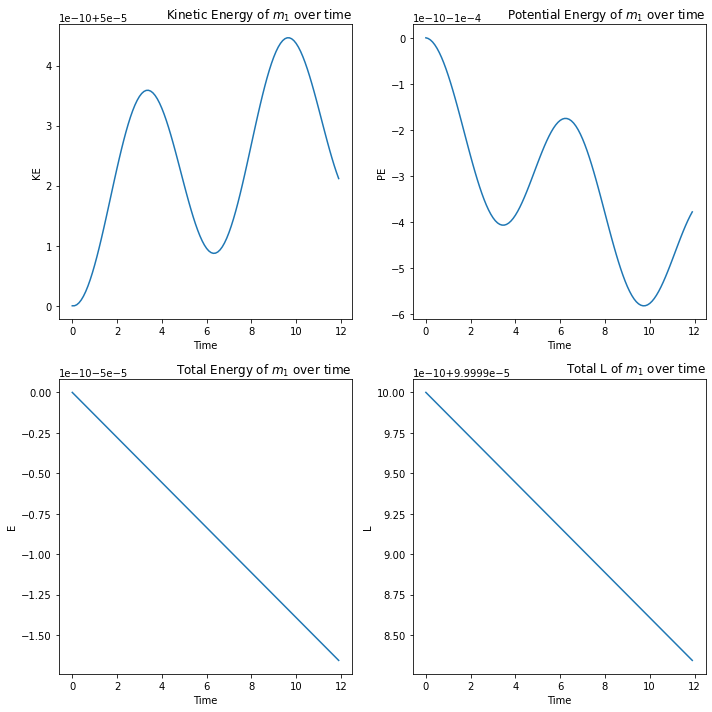

In [17]:
figs2, ax2 = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10), tight_layout = True)

ax2[0,0].plot(tarr, KE)
ax2[0,0].set_title(r"Kinetic Energy of $m_1$ over time", loc = 'right')
ax2[0,0].set_xlabel("Time")
ax2[0,0].set_ylabel("KE")

ax2[0,1].plot(tarr, PE)
ax2[0,1].set_title(r"Potential Energy of $m_1$ over time", loc = 'right')
ax2[0,1].set_xlabel("Time")
ax2[0,1].set_ylabel("PE")

ax2[1,0].plot(tarr, KE+PE)
ax2[1,0].set_title(r"Total Energy of $m_1$ over time", loc = 'right')
ax2[1,0].set_xlabel("Time")
ax2[1,0].set_ylabel("E")

ax2[1,1].plot(tarr, angular_momentum)
ax2[1,1].set_title(r"Total L of $m_1$ over time", loc = 'right')
ax2[1,1].set_xlabel("Time")
ax2[1,1].set_ylabel("L")

plt.savefig("rk4E.jpg", dpi=300)

So we can see that kinetic, potential, and therefore total energy is completely conserved, as is the total angular momentum. The energies and the angular momentum of $m_2$ should be zero, as it has no velocity, nor does it change in position at any time.

This concludes the second logbook.